In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


import missingno as msno
import warnings

# Suppress future warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# Setting the aesthetics for plots
sns.set_theme(style="whitegrid")

In [3]:
# Load the dataset
cirrhosis = pd.read_csv('./../../data/cirrhosis.csv')
    
# Convert 'NA' strings to actual NaN values
cirrhosis.replace('NA', pd.NA, inplace=True)
cirrhosis.replace('D-penicillamine', 'DPCA', inplace=True)

# Define column transformer for preprocessing
numeric_columns = ['Age', 'N_Days', 'Cholesterol', 'Tryglicerides', 'Albumin', 'Bilirubin', 'Copper', 'Alk_Phos', 'SGOT', 'Platelets', 'Prothrombin']
categoric_columns = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage', 'Status']

# Subsets of categoric columns
binary_columns = ['Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders']
presence_mapping = {'N': 0, 'Y': 1}
binary_mappings = {
    'Sex': {'F': 0, 'M': 1},
    'Drug': {'Placebo': 0, 'DPCA': 1},
    'Ascites': presence_mapping, 
    'Hepatomegaly': presence_mapping, 
    'Spiders': presence_mapping
}

ordinal_columns = ['Edema', 'Stage', 'Status']
ordinal_mappings = {
    'Edema': {'N': 0, 'S': 0.5, 'Y': 1}, 
    'Stage': {1: 0, 2: 1, 3: 2, 4: 3},
    'Status': {'C': 0, 'CL': 0.5, 'D': 1}
}

categoric_mappings = {col: binary_mappings[col] for col in binary_columns}
for col in ordinal_columns:
    categoric_mappings[col] = ordinal_mappings[col]

# Convert Age from days to years and round to 1 decimal place
cirrhosis['Age'] = (cirrhosis['Age'] / 365).round(1)

# # Convert categoric to such
# cirrhosis[categoric_columns] = cirrhosis[categoric_columns].astype('category')

# # Define order of ordinal 
# for column in ordinal_columns:
#     cirrhosis[column] = pd.Categorical(cirrhosis[column], categories=list(ordinal_mappings[column].keys()), ordered=True)

# Only use the defined columns
cirrhosis = cirrhosis[numeric_columns + categoric_columns]

# Apply mappings
mappings = [binary_mappings, ordinal_mappings]
for mapping in mappings:
    for column, m in mapping.items():
        cirrhosis[column] = cirrhosis[column].map(m)


## Handling missing data

In [4]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def imput(df, imputation_features, columns_to_impute):
    
    estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    # Create the imputer
    imputer = IterativeImputer(estimator=estimator, random_state=42, max_iter=10)
    
    # Extract the subset of the dataframe for imputation
    imputation_subset = df[imputation_features]

    # Apply imputation
    imputed_data = imputer.fit_transform(imputation_subset)
    
    # Create a dataframe from the imputed data with the same columns as the subset
    imputed_df = pd.DataFrame(imputed_data, columns=imputation_features, index=df.index)

    # Replace only the specified columns in the original dataframe with the imputed values
    for column in columns_to_impute:
        if column in imputation_features:
            if column in categoric_columns:
                if column == 'Stage':
                    imputed_df[column] = imputed_df[column].round().astype(int).clip(0, 3)
                elif column == 'Status':
                    imputed_df[column] = imputed_df[column].round(1).clip(0, 1)
                    imputed_df[column] = imputed_df[column].apply(lambda x: 0 if x < 0.33 else (0.5 if x < 0.66 else 1))
                else:
                    imputed_df[column] = imputed_df[column].round(1).clip(0, 1)
                # imputed_df[column] = imputed_df[column].astype('category')
            # Replace the column in the original dataframe
            df[column] = imputed_df[column]

    # Check the result for missing values
    print(df[columns_to_impute].isnull().sum())
    # msno.matrix(df)

# Imput data for the cirrhosis dataframe
imput(cirrhosis, ['Age', 'N_Days', 'Albumin', 'Bilirubin', 'Platelets', 'Prothrombin', 'Sex', 'Edema', 'Stage', 'Status'], ['Platelets', 'Prothrombin', 'Stage'])

# # Define order of ordinal 
# for column in ordinal_columns:
#     cirrhosis[column] = pd.Categorical(cirrhosis[column], categories=list(ordinal_mappings[column].values()), ordered=True)

# Divide the dataset in trial and non-trial patients
trials = cirrhosis.dropna(subset=['Drug'])
non_trials = cirrhosis.query('Drug.isna()').reset_index(drop=True)

# Imput data for the trials datset
imput(trials, list(trials.columns), ['Cholesterol', 'Tryglicerides', 'Copper'])

# # Define order of ordinal 
# for column in ordinal_columns:
#     trials[column] = pd.Categorical(trials[column], categories=list(ordinal_mappings[column].values()), ordered=True)

# Ensemble back the complete dataset with no missing values
cirrhosis = pd.concat([trials, non_trials], ignore_index=True)

# Check the result for missing values
print(cirrhosis.isnull().sum())

Platelets      0
Prothrombin    0
Stage          0
dtype: int64
Cholesterol      0
Tryglicerides    0
Copper           0
dtype: int64
Age                0
N_Days             0
Cholesterol      106
Tryglicerides    106
Albumin            0
Bilirubin          0
Copper           106
Alk_Phos         106
SGOT             106
Platelets          0
Prothrombin        0
Sex                0
Drug             106
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Stage              0
Status             0
dtype: int64


/var/folders/_y/b9yjk1tn06n3_r7rt2vryzv80000gq/T/ipykernel_88464/2020407050.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = imputed_df[column]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            418 non-null    float64
 1   N_Days         418 non-null    int64  
 2   Cholesterol    312 non-null    float64
 3   Tryglicerides  312 non-null    float64
 4   Albumin        418 non-null    float64
 5   Bilirubin      418 non-null    float64
 6   Copper         312 non-null    float64
 7   Alk_Phos       312 non-null    float64
 8   SGOT           312 non-null    float64
 9   Platelets      418 non-null    float64
 10  Prothrombin    418 non-null    float64
 11  Sex            418 non-null    int64  
 12  Drug           312 non-null    float64
 13  Ascites        312 non-null    float64
 14  Hepatomegaly   312 non-null    float64
 15  Spiders        312 non-null    float64
 16  Edema          418 non-null    float64
 17  Stage          418 non-null    int64  
 18  Status    

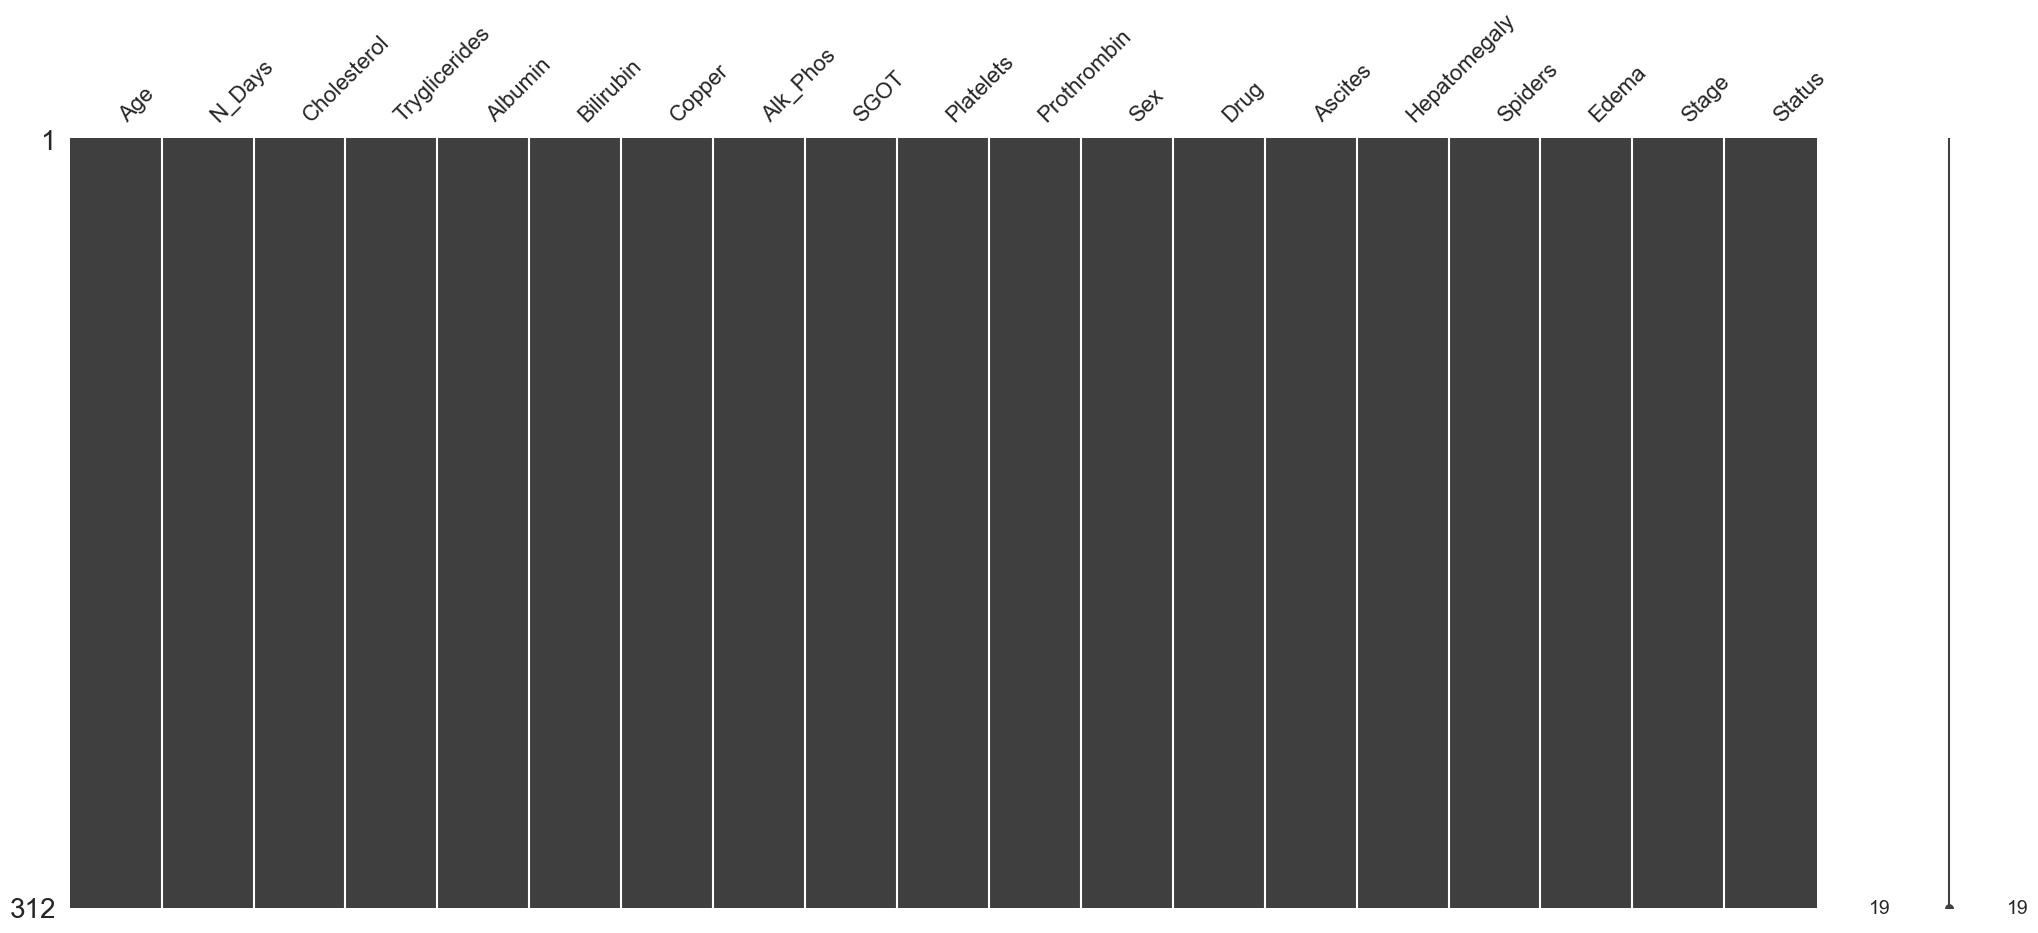

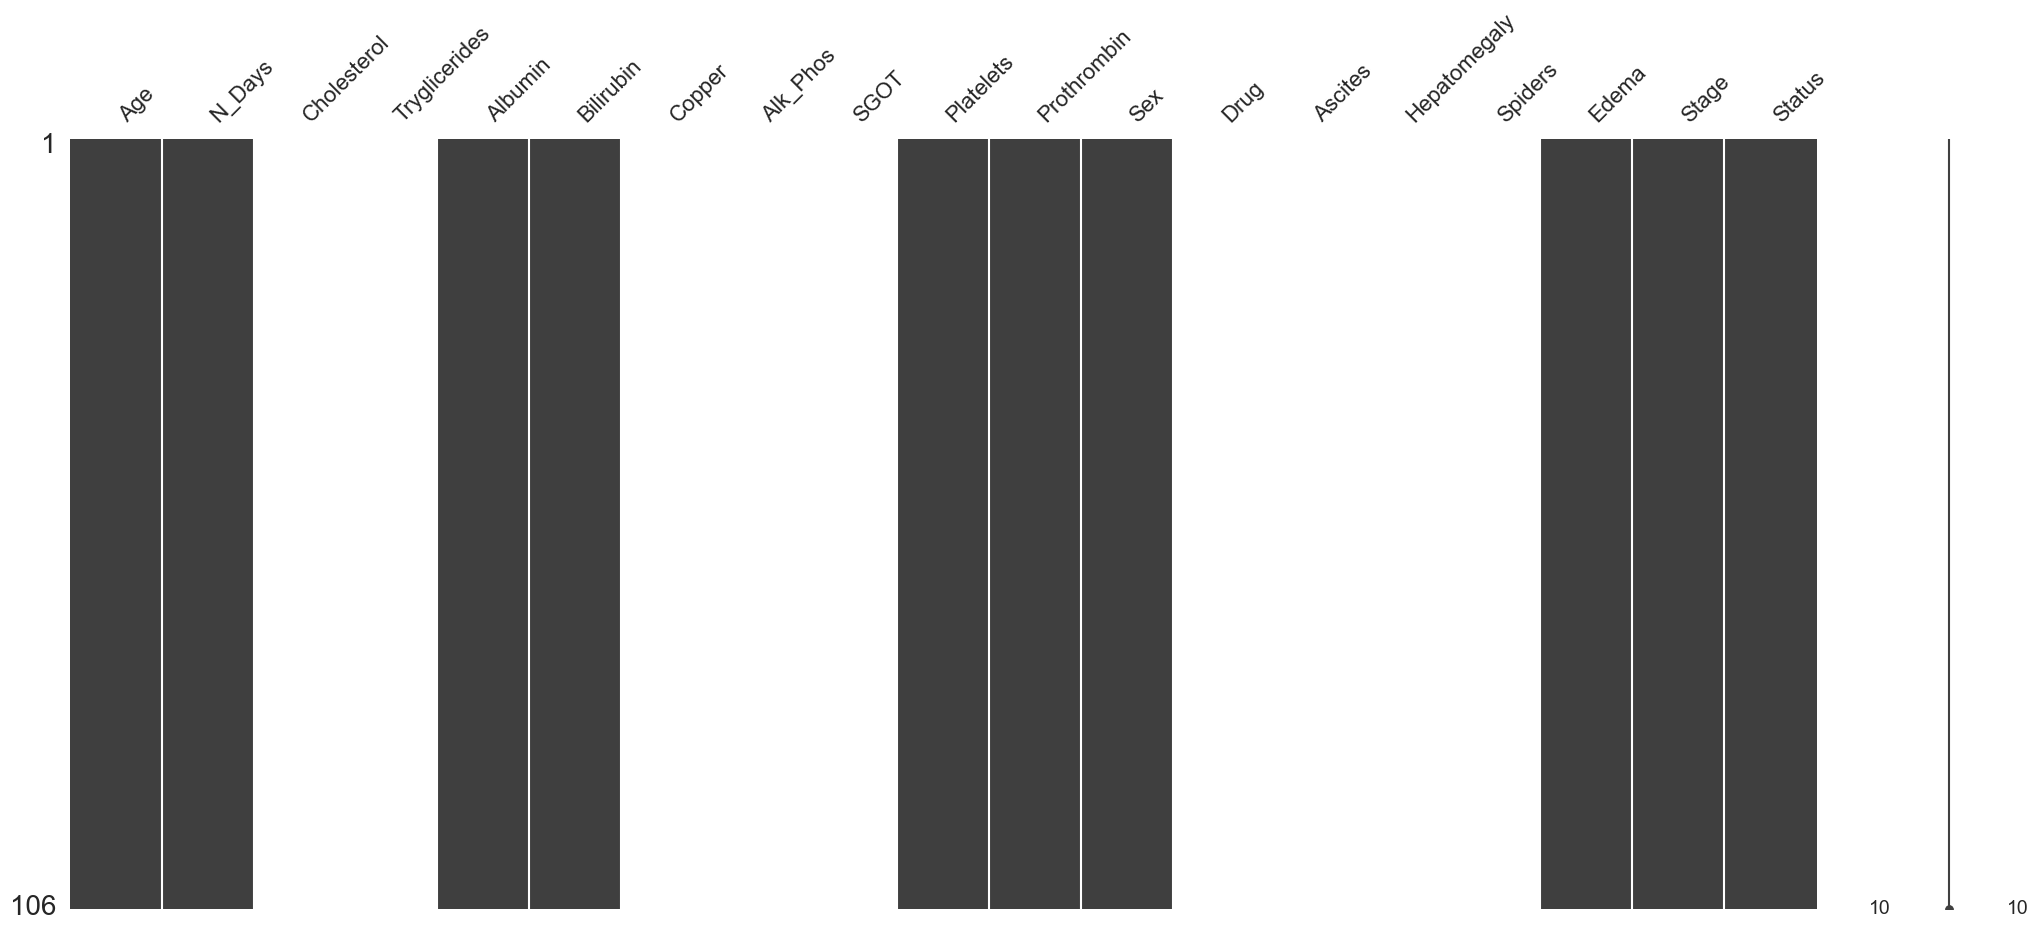

In [5]:
msno.matrix(trials)
msno.matrix(non_trials)
cirrhosis.info()

## Starting survival model

Iteration 1: norm_delta = 1.88e+00, step_size = 0.9500, log_lik = -639.96649, newton_decrement = 1.60e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.12e+00, step_size = 0.9500, log_lik = -706.72307, newton_decrement = 3.16e+02, seconds_since_start = 0.0
Iteration 3: norm_delta = 9.43e+00, step_size = 0.9500, log_lik = -729.24771, newton_decrement = 6.80e+02, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.47e+00, step_size = 0.2327, log_lik = -632.35630, newton_decrement = 1.13e+02, seconds_since_start = 0.0
Iteration 5: norm_delta = 5.84e-01, step_size = 0.2965, log_lik = -576.80796, newton_decrement = 3.16e+01, seconds_since_start = 0.0
Iteration 6: norm_delta = 2.26e-01, step_size = 0.5011, log_lik = -553.35707, newton_decrement = 6.95e+00, seconds_since_start = 0.0
Iteration 7: norm_delta = 5.10e-02, step_size = 0.8469, log_lik = -546.34431, newton_decrement = 4.45e-01, seconds_since_start = 0.0
Iteration 8: norm_delta = 4.62e-03, step_size = 1.0000, log_lik = -54

<lifelines.CoxPHFitter: fitted with 312 total observations, 187 right-censored observations>
             duration col = 'N_Days'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 312
number of events observed = 125
   partial log-likelihood = -545.88
         time fit was run = 2024-05-03 02:27:10 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
Bilirubin      0.08      1.09      0.02            0.04            0.13                1.04                1.14
Spiders        0.29      1.33      0.21           -0.13            0.70                0.88                2.02
Alk_Phos       0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Edema          0.85      2.35      0.34            0.19            1.52                1.21                4.55
Tryglicerides -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Drug           0.01      1.01      0.20           -0.37            0.40                0.69                1.49
Hepatomegaly   0.51      1.66      0.22            0.08            0.93                1.08                2.54
Albumin       -0.87      0.42      0.27           -1.39           -0.35                0.25                0.71
Cholesterol    0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Age            0.04      1.04      0.01            0.01            0.06                1.01                1.06
Sex            0.41      1.51      0.27           -0.11            0.94                0.89                2.56
Prothrombin    0.27      1.31      0.08            0.11            0.44                1.11                1.55
Platelets      0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Ascites        0.48      1.61      0.33           -0.16            1.12                0.85                3.05
SGOT           0.00      1.00      0.00            0.00            0.01                1.00                1.01

               cmp to     z      p  -log2(p)
covariate                                   
Bilirubin        0.00  3.71 <0.005     12.21
Spiders          0.00  1.35   0.18      2.51
Alk_Phos         0.00  0.20   0.84      0.25
Edema            0.00  2.53   0.01      6.45
Tryglicerides    0.00 -0.62   0.53      0.91
Drug             0.00  0.06   0.95      0.07
Hepatomegaly     0.00  2.33   0.02      5.65
Albumin          0.00 -3.25 <0.005      9.78
Cholesterol      0.00  0.59   0.55      0.85
Age              0.00  3.36 <0.005     10.35
Sex              0.00  1.54   0.12      3.02
Prothrombin      0.00  3.25 <0.005      9.77
Platelets        0.00  0.30   0.77      0.38
Ascites          0.00  1.47   0.14      2.81
SGOT             0.00  2.65   0.01      6.95
---
Concordance = 0.84
Partial AIC = 1121.75
log-likelihood ratio test = 188.18 on 15 df
-log2(p) of ll-ratio test = 103.90

<Axes: xlabel='log(HR) (95% CI)'>

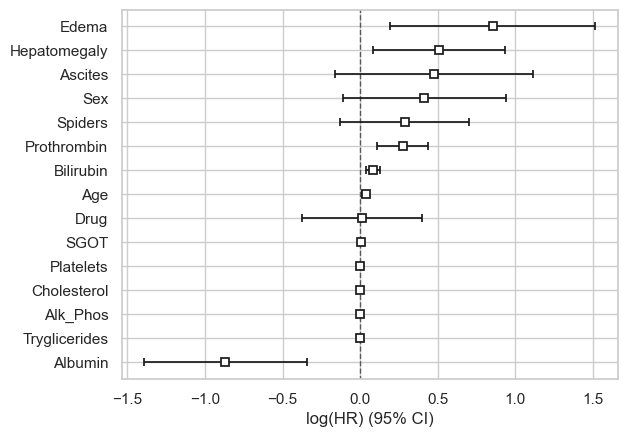

In [7]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import datetimes_to_durations
from lifelines.utils import k_fold_cross_validation
from sklearn.model_selection import StratifiedKFold

# Defining the failure events: Deaths
for df in [cirrhosis, trials, non_trials]:
    df['Event'] = df['Status'].apply(lambda x: 1 if x == 1 else 0)

# Create the Cox Proportional Hazard model
cph = CoxPHFitter()

# Using only a subset of columns for this example, add or remove based on your analysis
covariates = list(set(trials.columns) - set(['N_Days', 'Event', 'Status', 'Stage', 'Copper']))

# Fit the model
cph.fit(trials[covariates + ['N_Days', 'Event']], duration_col='N_Days', event_col='Event', show_progress=True)

# Examine the resuts
cph.print_summary()

# Plot the results
cph.plot()


In [ ]:
# Check the model assumptions
cph.check_assumptions(trials[covariates + ['N_Days', 'Event']], p_value_threshold=0.05)

In [ ]:

# Perform cross-validation
scores = k_fold_cross_validation(cph, trials[covariates + ['N_Days', 'Event']], 'N_Days', event_col='Event', k=3)
print("Cross-validated Concordance Index:", np.mean(scores))

In [ ]:
# Extract coefficients and their confidence intervals
coef = cph.summary['coef']
confidence_intervals = cph.summary[['coef lower 95%', 'coef upper 95%']]
p_values = cph.summary['p']

# Display a summary dataframe of coefficients and their statistics
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Coefficient': coef,
    'Lower CI': confidence_intervals['coef lower 95%'],
    'Upper CI': confidence_intervals['coef upper 95%'],
    'p': p_values
}).sort_values(by='Coefficient', key=abs, ascending=False).query('p<=0.05')  # Sorting by absolute value of coefficients

print(feature_importance_df)

In [ ]:
# Define the number of folds
n_splits = 5

# Prepare the stratification based on the event status
stratify_criteria = trials['Event']  # This assumes 'Event' is your binary indicator of the event occurrence

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Cox Proportional Hazards model
cph = CoxPHFitter()

concordance_indexes = []

for train_index, test_index in skf.split(trials, stratify_criteria):
    # Split data
    X_train, X_test = trials.iloc[train_index], trials.iloc[test_index]

    # Fit the Cox model on the training data
    cph.fit(X_train[covariates + ['N_Days', 'Event']], duration_col='N_Days', event_col='Event')

    # Evaluate the model on the test data
    # We use the concordance index as the performance metric
    concordance_index = cph.score(X_test[covariates + ['N_Days', 'Event']], scoring_method="concordance_index")
    concordance_indexes.append(concordance_index)

# Calculate the average concordance index across all folds
average_c_index = np.mean(concordance_indexes)
print("Average Concordance Index across all folds: ", average_c_index)

In [ ]:
ax = plt.subplot(111)

# Compute and plot the baseline survival
cph.baseline_survival_.plot(ax=ax, legend=False)
ax.set_title('Baseline Survival Function')
ax.set_ylabel('Survival Probability')
# Convert x-axis from days to years
ticks = ax.get_xticks()  # Get current x-tick locations (in days)
new_tick_labels = [f"{int(tick / 365)} yrs" for tick in ticks]  # Convert day ticks to year labels
ax.set_xticklabels(new_tick_labels)  # Set new tick labels
ax.set_xlabel('Years')  # Update x-axis label to 'Years'
plt.show()

In [ ]:

# Plot the baseline survival curve
ax = plt.subplot(111)
cph.baseline_survival_.plot(ax=ax, legend=False, color='grey', linestyle='--')

# Choose two random patients
random_patients = trials.sample(n=2)

# Predict the survival function for these two patients
survival_functions = cph.predict_survival_function(random_patients)

# Plot the survival function for each random patient
for i, patient_id in enumerate(random_patients.index):
    survival_functions.loc[:, patient_id].plot(ax=ax, label=f'Patient {patient_id}')

# Set up the plot
ax.set_title('Baseline Survival Function with Two Random Patients')
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Years')

# Convert x-axis from days to years
ticks = ax.get_xticks()  # Get current x-tick locations (in days)
ax.set_xticks(ticks)  # Set new tick locations
new_tick_labels = [f"{int(tick / 365)} yrs" for tick in ticks]  # Convert day ticks to year labels
ax.set_xticklabels(new_tick_labels)  # Set new tick labels

# Add the legend
ax.legend()

plt.show()

In [ ]:
# Assuming 'cph' is your fitted CoxPHFitter object
fig, ax = plt.subplots(figsize=(5, 5))
cph.plot_partial_effects_on_outcome(covariates='Drug', values=[0, 1], ax=ax)
ax.set_title('Survival Curves by Drug Treatment')
ax.set_ylabel('Survival Probability')
# Convert x-axis from days to years
ticks = ax.get_xticks()  # Get current x-tick locations (in days)
new_tick_labels = [f"{int(tick / 365)} yrs" for tick in ticks]  # Convert day ticks to year labels
ax.set_xticklabels(new_tick_labels)  # Set new tick labels
ax.set_xlabel('Years')  # Update x-axis label to 'Years'
plt.show()

In [ ]:
from lifelines import KaplanMeierFitter

# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Assuming 'N_Days' is the time to event or censoring and 'Event' is the event occurrence (1 if event occurred, 0 if censored)
kmf.fit(trials['N_Days'], event_observed=trials['Event'])

# Plot the survival function
kmf.plot_survival_function()

# Customize the plot with titles and labels
plt.title('Overall Kaplan-Meier Survival Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [ ]:
# Initialize and fit Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(trials['N_Days'], trials['Event'])  # Assuming trials DataFrame has 'N_Days' and 'Event' columns

# Create a plot
fig, ax = plt.subplots()

# Plot Kaplan-Meier Survival Curve
kmf.plot_survival_function(ax=ax, label='Kaplan-Meier Estimate')

# Plot Cox Baseline Survival Function
cph.baseline_survival_.plot(ax=ax, legend=False, label='Cox Baseline Survival', color='red')

# Set title and labels with modified x-axis for years
ax.set_title('Comparison of Baseline Survival (Cox) and Kaplan-Meier')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Survival Probability')

# Convert x-axis from days to years
ticks = ax.get_xticks()  # Get current x-tick locations (in days)
new_tick_labels = [f"{int(tick / 365)} yrs" for tick in ticks]  # Convert day ticks to year labels
ax.set_xticklabels(new_tick_labels)  # Set new tick labels

# Add legend to distinguish the curves
ax.legend()

plt.show()

In [ ]:
# Define the number of folds
n_splits = 5

# Prepare the stratification based on the event status
stratify_criteria = trials['Event']  # This assumes 'Event' is your binary indicator of the event occurrence

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Cox Proportional Hazards model
cph = CoxPHFitter()

concordance_indexes = []

for train_index, test_index in skf.split(trials, stratify_criteria):
    # Split data
    X_train, X_test = trials.iloc[train_index], trials.iloc[test_index]

    # Fit the Cox model on the training data
    cph.fit(X_train[covariates + ['N_Days', 'Event']], duration_col='N_Days', event_col='Event')

    # Evaluate the model on the test data
    # We use the concordance index as the performance metric
    concordance_index = cph.score(X_test[covariates + ['N_Days', 'Event']], scoring_method="concordance_index")
    concordance_indexes.append(concordance_index)

# Calculate the average concordance index across all folds
average_c_index = np.mean(concordance_indexes)
print("Average Concordance Index across all folds: ", average_c_index)

In [8]:
# Define the number of folds
n_splits = 5

# Prepare the stratification based on the event status
stratify_criteria = trials['Event']  # This assumes 'Event' is your binary indicator of the event occurrence

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Cox Proportional Hazards model
cph = CoxPHFitter()

concordance_indexes = []

numeric_columns_to_transform = ['Albumin', 'Prothrombin', 'SGOT']
# Apply log transformation, adding a small constant to avoid log(0)
for column in numeric_columns_to_transform:
    trials[f"log_{column}"] = np.log(trials[column])
    
covariates = ['Edema', 'log_Albumin', 'log_Prothrombin', 'Age', 'log_SGOT']

for train_index, test_index in skf.split(trials, stratify_criteria):
    # Split data
    X_train, X_test = trials.iloc[train_index], trials.iloc[test_index]

    # Fit the Cox model on the training data
    cph.fit(X_train[covariates + ['N_Days', 'Event']], duration_col='N_Days', event_col='Event')

    # Evaluate the model on the test data
    # We use the concordance index as the performance metric
    concordance_index = cph.score(X_test[covariates + ['N_Days', 'Event']], scoring_method="concordance_index")
    concordance_indexes.append(concordance_index)

# Calculate the average concordance index across all folds
average_c_index = np.mean(concordance_indexes)
print("Average Concordance Index across all folds: ", average_c_index)

Average Concordance Index across all folds:  0.8149941633729643


Iteration 1: norm_delta = 6.14e+00, step_size = 0.9500, log_lik = -639.96649, newton_decrement = 1.75e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.03e+00, step_size = 0.2375, log_lik = -571.45876, newton_decrement = 3.92e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 7.09e-01, step_size = 0.3087, log_lik = -550.99464, newton_decrement = 1.96e+01, seconds_since_start = 0.0
Iteration 4: norm_delta = 6.61e-01, step_size = 0.5218, log_lik = -535.63037, newton_decrement = 6.29e+00, seconds_since_start = 0.0
Iteration 5: norm_delta = 3.28e-01, step_size = 0.8818, log_lik = -529.03035, newton_decrement = 4.48e-01, seconds_since_start = 0.0
Iteration 6: norm_delta = 2.28e-02, step_size = 1.0000, log_lik = -528.56634, newton_decrement = 1.49e-03, seconds_since_start = 0.0
Iteration 7: norm_delta = 7.90e-05, step_size = 1.0000, log_lik = -528.56485, newton_decrement = 1.84e-08, seconds_since_start = 0.0
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 312 total observations, 187 right-censored observations>
             duration col = 'N_Days'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 312
number of events observed = 125
   partial log-likelihood = -528.56
         time fit was run = 2024-05-03 02:38:29 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                          
log_Albumin       -5.89      0.00      5.57          -16.80            5.02                0.00              151.65
log_Prothrombin   -0.69      0.50     14.76          -29.61           28.23                0.00            1.83e+12
log_SGOT           0.85      2.35      0.78           -0.68            2.39                0.51               10.89
log_Bilirubin      0.61      1.84      0.25            0.12            1.10                1.13                3.00
log_Tryglicerides  0.89      2.43      0.61           -0.32            2.09                0.73                8.09
log_Alk_Phos       0.20      1.22      0.40           -0.59            0.98                0.56                2.66
log_Copper         0.51      1.66      0.31           -0.10            1.11                0.90                3.05
log_Cholesterol    0.27      1.31      0.73           -1.17            1.71                0.31                5.52
log_Platelets      0.39      1.47      0.91           -1.41            2.18                0.25                8.81
Bilirubin         -0.01      0.99      0.04           -0.09            0.06                0.91                1.07
Tryglicerides     -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
Alk_Phos          -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Copper            -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
Albumin            1.18      3.25      1.78           -2.31            4.67                0.10              106.37
Cholesterol       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Prothrombin        0.38      1.46      1.26           -2.09            2.84                0.12               17.20
Platelets         -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
SGOT              -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
Age                0.03      1.03      0.01            0.01            0.05                1.01                1.05
Sex                0.04      1.04      0.30           -0.55            0.64                0.58                1.89
Drug              -0.01      0.99      0.21           -0.43            0.41                0.65                1.51
Ascites            0.41      1.51      0.34           -0.25            1.08                0.78                2.94
Hepatomegaly       0.11      1.11      0.24           -0.37            0.59                0.69                1.80
Spiders            0.03      1.03      0.23           -0.42            0.48                0.66                1.62
Edema              0.99      2.68      0.35            0.29            1.68                1.34                5.37
Stage              0.27      1.32      0.17           -0.05            0.60                0.95                1.82

                   cmp to     z    p  -log2(p)
covariate                                     
log_Albumin          0.00 -1.06 0.29      1.79
log_Prothrombin      0.00 -0.05 0.96      0.05
log_SGOT             0.00  1.09 0.28      1.86
log_Bilirubin        0.00  2.45 0.01      6.13
log_Tryglicerides    0.00  1.44 0.15      2.74
log_Alk_Phos         0.00  0.49 0.62      0.68
log_Copper      

<Axes: xlabel='log(HR) (95% CI)'>

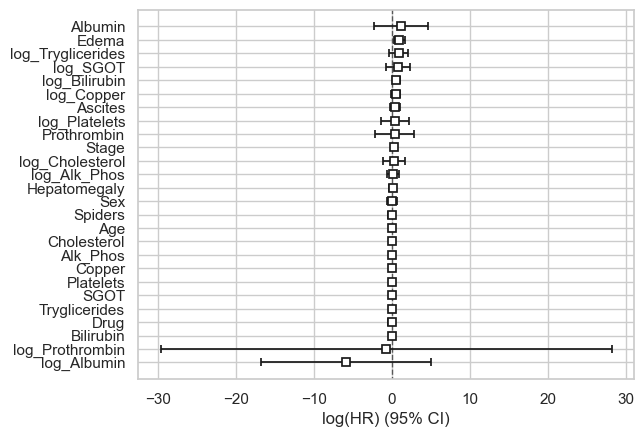

In [9]:
# List of numeric columns to transform, excluding 'Age' and 'N_Days'
numeric_columns_to_transform = list(set(numeric_columns) - set(['Age', 'N_Days']))
# Apply log transformation, adding a small constant to avoid log(0)
for column in numeric_columns_to_transform:
    trials[f"log_{column}"] = np.log(trials[column])  # Using log(x+1) to handle zero values
    # trials[f'sq_{column}'] = trials[column]**2
    # trials[f'sqrt_{column}'] = np.sqrt(trials[column])
    
covariates = [col for col in trials.columns if 'log' in col or 'sq' in col or 'sqrt' in col]
covariates.extend(numeric_columns_to_transform)
covariates.extend(['Age', 'Sex', 'Drug', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'])

# Create the Cox Proportional Hazard model
cph = CoxPHFitter()

# Fit the model
cph.fit(trials[covariates + ['N_Days', 'Event']], duration_col='N_Days', event_col='Event', show_progress=True)

# Print and examine the results
cph.print_summary()

# Optionally, plot the results
cph.plot()

In [ ]:
# Extract coefficients and their confidence intervals
coef = cph.summary['coef']
confidence_intervals = cph.summary[['coef lower 95%', 'coef upper 95%']]
p_values = cph.summary['p']

# Display a summary dataframe of coefficients and their statistics
import pandas as pd
feature_importance_df = pd.DataFrame({
    'Coefficient': coef,
    'Lower CI': confidence_intervals['coef lower 95%'],
    'Upper CI': confidence_intervals['coef upper 95%'],
    'p': p_values
}).sort_values(by='Coefficient', key=abs, ascending=False).query('p<=0.05')  # Sorting by absolute value of coefficients

feature_importance_df

In [ ]:
# Define the number of folds
n_splits = 5

# Prepare the stratification based on the event status
stratify_criteria = trials['Event']  # This assumes 'Event' is your binary indicator of the event occurrence

# Initialize the StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize Cox Proportional Hazards model
cph = CoxPHFitter()

concordance_indexes = []

for train_index, test_index in skf.split(trials, stratify_criteria):
    # Split data
    X_train, X_test = trials.iloc[train_index], trials.iloc[test_index]

    # Fit the Cox model on the training data
    cph.fit(X_train[covariates + ['N_Days', 'Event']], duration_col='N_Days', event_col='Event')

    # Evaluate the model on the test data
    # We use the concordance index as the performance metric
    concordance_index = cph.score(X_test[covariates + ['N_Days', 'Event']], scoring_method="concordance_index")
    concordance_indexes.append(concordance_index)

# Calculate the average concordance index across all folds
average_c_index = np.mean(concordance_indexes)
print("Average Concordance Index across all folds: ", average_c_index)